<a href="https://colab.research.google.com/github/Summer99D/MLF_Final/blob/main/MLF_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install category_encoders pandas numpy seaborn missingno scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 106.9 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
test_trns_df= pd.read_csv('/content/drive/MyDrive/MLF/test_transaction.csv')
test_id_df= pd.read_csv('/content/drive/MyDrive/MLF/test_identity.csv')
train_trns_df= pd.read_csv('/content/drive/MyDrive/MLF/train_transaction.csv')
train_id_df= pd.read_csv('/content/drive/MyDrive/MLF/train_identity.csv')


In [7]:
print(test_trns_df.describe)

<bound method NDFrame.describe of         TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224          31.950         W  10409  111.0   
1             3663550       18403263          49.000         W   4272  111.0   
2             3663551       18403310         171.000         W   4476  574.0   
3             3663552       18403310         284.950         W  10989  360.0   
4             3663553       18403317          67.950         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279          94.679         C  13832  375.0   
506687        4170236       34214287          12.173         C   3154  408.0   
506688        4170237       34214326          49.000         W  16661  490.0   
506689        4170238       34214337         202.000         W  16621  516.0   
506690        4170239       34214345          24.346         C   5713  168.0   

     

In [8]:
print(test_id_df.describe)

<bound method NDFrame.describe of         TransactionID  id-01     id-02  id-03  id-04  id-05  id-06  id-07  \
0             3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN   
1             3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN   
2             3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN   
3             3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN   
4             3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN   
...               ...    ...       ...    ...    ...    ...    ...    ...   
141902        4170230  -20.0  473365.0    NaN    NaN    0.0    0.0    NaN   
141903        4170233   -5.0  489917.0    0.0    0.0   -4.0  -32.0    NaN   
141904        4170234   -5.0  110081.0    NaN    NaN   22.0  -31.0    NaN   
141905        4170236  -45.0  266704.0    NaN    NaN   -3.0  -10.0    NaN   
141906        4170239  -10.0  692090.0    0.0    0.0    0.0    0.0    NaN   

        id-08  id-09  ...                

In [9]:
print(train_id_df.describe)
print(train_id_df.columns)

<bound method NDFrame.describe of         TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  \
0             2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN   
1             2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN   
2             2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN   
3             2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN   
4             2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN   
...               ...    ...       ...    ...    ...    ...    ...    ...   
144228        3577521  -15.0  145955.0    0.0    0.0    0.0    0.0    NaN   
144229        3577526   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN   
144230        3577529  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN   
144231        3577531   -5.0   55528.0    0.0    0.0    0.0   -7.0    NaN   
144232        3577534  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN   

        id_08  id_09  ...                

In [10]:
print(train_trns_df.describe)
print(train_trns_df.columns)

<bound method NDFrame.describe of         TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5  ... V330  V331  V

In [11]:
## I will be merging on "transaction id"
train_merged= pd.merge(train_trns_df, train_id_df, on='TransactionID', how='left')
test_merged= pd.merge(test_trns_df, test_id_df, on='TransactionID', how='left')

In [12]:
print(train_merged.shape)## we have 434 variables
print(test_merged.shape)

(590540, 434)
(506691, 433)


### Inspecting NaNs

Training data

In [13]:
# Step 1: Calculate NaN statistics
nan_percentage_train = train_merged.isnull().mean() * 100
nan_percentage_train = nan_percentage_train.sort_values(ascending=False)

# Step 2: Summary statistics
print("NaN Distribution Across Columns:")
print(f"Total rows: {train_merged.shape[0]}")
print(f"Total columns: {train_merged.shape[1]}")
print(f"Columns with >30% missing values: {(nan_percentage_train > 30).sum()}") ##removing columns with more than 30% missing vlaues
print("\nTop 10 columns with highest missing values:")
print(nan_percentage_train.head(10))


NaN Distribution Across Columns:
Total rows: 590540
Total columns: 434
Columns with >30% missing values: 232

Top 10 columns with highest missing values:
id_24    99.196159
id_25    99.130965
id_07    99.127070
id_08    99.127070
id_21    99.126393
id_26    99.125715
id_22    99.124699
id_27    99.124699
id_23    99.124699
dist2    93.628374
dtype: float64


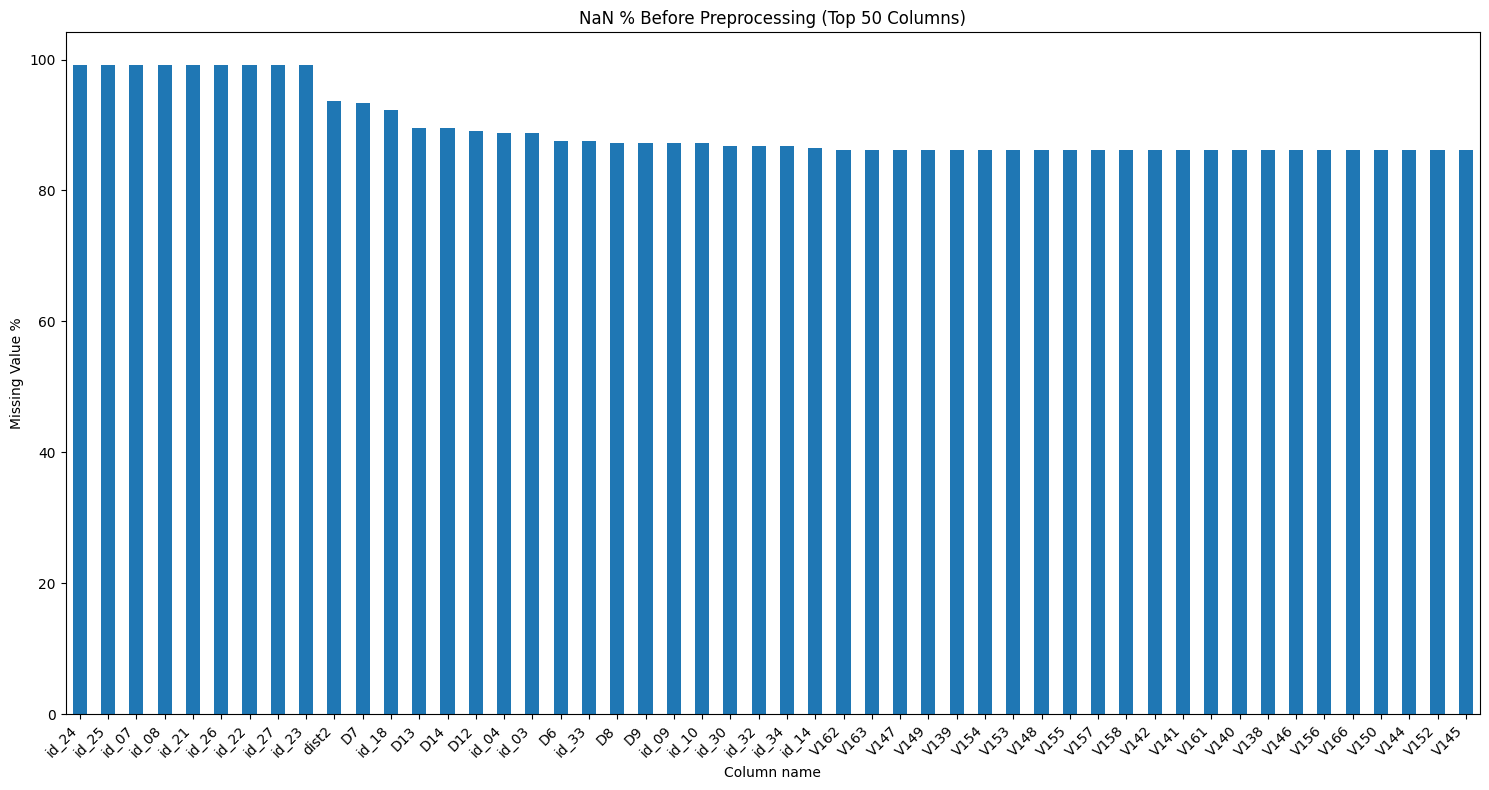

In [14]:
# Plot 1: Bar plot of NaN percentages (top 50 columns)
plt.figure(figsize=(15, 8))
nan_percentage_train.head(50).plot(kind='bar')
plt.title('NaN % Before Preprocessing (Top 50 Columns)')
plt.xlabel('Column name')
plt.ylabel('Missing Value %')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/nan_bar_plot_before.png')
plt.show()

In [15]:
print(nan_percentage_train.describe)

<bound method NDFrame.describe of id_24             99.196159
id_25             99.130965
id_07             99.127070
id_08             99.127070
id_21             99.126393
                    ...    
ProductCD          0.000000
TransactionAmt     0.000000
TransactionDT      0.000000
isFraud            0.000000
TransactionID      0.000000
Length: 434, dtype: float64>


In [16]:
# Remove columns with >30% missing values
columns_to_drop = nan_percentage_train[nan_percentage_train > 30].index
print(f"Removing {len(columns_to_drop)} columns with >30% missing values:")
print(columns_to_drop.tolist())
train_data_cleaned = train_merged.drop(columns=columns_to_drop)

Removing 232 columns with >30% missing values:
['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_27', 'id_23', 'dist2', 'D7', 'id_18', 'D13', 'D14', 'D12', 'id_04', 'id_03', 'D6', 'id_33', 'D8', 'D9', 'id_09', 'id_10', 'id_30', 'id_32', 'id_34', 'id_14', 'V162', 'V163', 'V147', 'V149', 'V139', 'V154', 'V153', 'V148', 'V155', 'V157', 'V158', 'V142', 'V141', 'V161', 'V140', 'V138', 'V146', 'V156', 'V166', 'V150', 'V144', 'V152', 'V145', 'V164', 'V165', 'V159', 'V160', 'V151', 'V143', 'V329', 'V335', 'V336', 'V339', 'V337', 'V324', 'V327', 'V326', 'V325', 'V328', 'V322', 'V330', 'V338', 'V323', 'V334', 'V331', 'V333', 'V332', 'DeviceInfo', 'id_13', 'id_16', 'V230', 'V264', 'V265', 'V266', 'V252', 'V260', 'V261', 'V263', 'V262', 'V273', 'V274', 'V269', 'V268', 'V267', 'V278', 'V277', 'V276', 'V275', 'V248', 'V235', 'V249', 'V244', 'V243', 'V246', 'V247', 'V257', 'V258', 'V253', 'V236', 'V240', 'V241', 'V242', 'V237', 'V218', 'V231', 'V229', 'V254', 'V228', 'V232', 'V219',

In [17]:
## I wanna check data types
train_data_cleaned.dtypes

,0
TransactionID,int64
isFraud,int64
TransactionDT,int64
TransactionAmt,float64
ProductCD,object
...,...
V317,float64
V318,float64
V319,float64
V320,float64


In [18]:
# Impute NaNs in all columns with the mean (for numeric columns only)
train_data_cleaned = train_data_cleaned.fillna(train_data_cleaned.mean(numeric_only=True))

In [19]:
from sklearn.impute import SimpleImputer

# Identify column types
num_cols = train_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
cat_cols = train_data_cleaned.select_dtypes(include=['object', 'category']).columns

num_imputer = SimpleImputer(strategy='mean')
train_data_cleaned[num_cols] = num_imputer.fit_transform(train_data_cleaned[num_cols])


cat_imputer = SimpleImputer(strategy='most_frequent')
train_data_cleaned[cat_cols] = cat_imputer.fit_transform(train_data_cleaned[cat_cols])


In [20]:
# Verify no NaNs
nan_percentage_cleaned = train_data_cleaned.isnull().mean() * 100
print("\nNaN percentages after imputation (should be 0%):")
print(nan_percentage_cleaned[nan_percentage_cleaned > 0])


NaN percentages after imputation (should be 0%):
Series([], dtype: float64)


Test Data

In [21]:
# Step 1: Calculate NaN statistics
nan_percentage_test = test_merged.isnull().mean() * 100
nan_percentage_test = nan_percentage_test.sort_values(ascending=False)

# Step 2: Summary statistics
print("NaN Distribution Across Columns:")
print(f"Total rows: {test_merged.shape[0]}")
print(f"Total columns: {test_merged.shape[1]}")
print(f"Columns with >30% missing values: {(nan_percentage_test > 30).sum()}") ##removing columns with more than 30% missing vlaues
print("\nTop 10 columns with highest missing values:")
print(nan_percentage_test.head(10))

NaN Distribution Across Columns:
Total rows: 506691
Total columns: 433
Columns with >30% missing values: 233

Top 10 columns with highest missing values:
id-24    99.064519
id-25    99.005508
id-26    99.003929
id-21    99.001561
id-08    99.001561
id-07    99.001561
id-27    99.000969
id-23    99.000969
id-22    99.000969
dist2    92.809030
dtype: float64


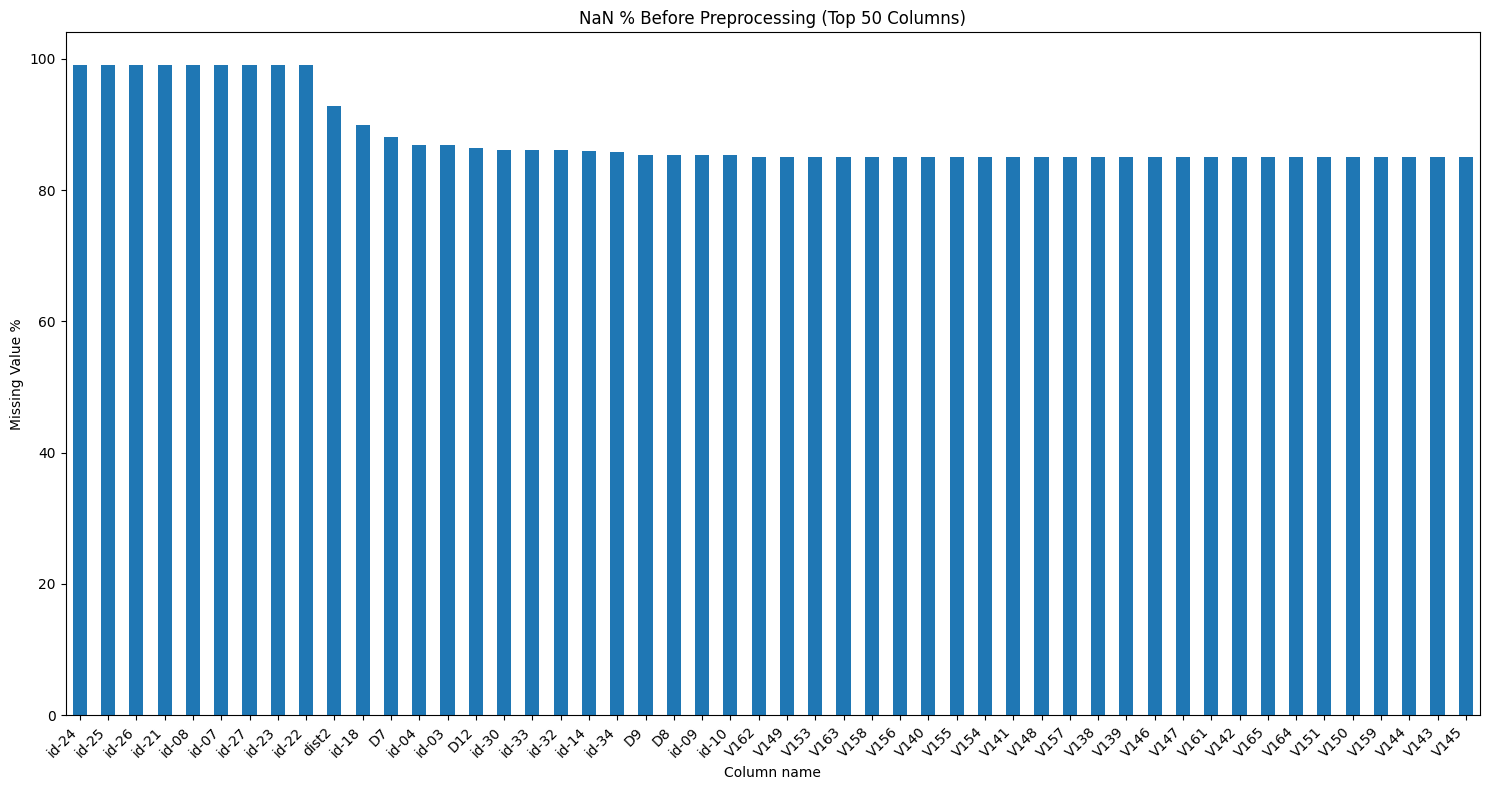

In [22]:
# Bar plot: Top 50 columns
plt.figure(figsize=(15, 8))
nan_percentage_test.head(50).plot(kind='bar')
plt.title('NaN % Before Preprocessing (Top 50 Columns)')
plt.xlabel('Column name')
plt.ylabel('Missing Value %')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/nan_bar_plot_before.png')
plt.show()

In [23]:
# Remove columns with >30% missing values
columns_to_drop_test = nan_percentage_test[nan_percentage_test > 30].index
print(f"Removing {len(columns_to_drop_test)} columns with >30% missing values:")
print(columns_to_drop_test.tolist())
test_data_cleaned = test_merged.drop(columns=columns_to_drop_test)

Removing 233 columns with >30% missing values:
['id-24', 'id-25', 'id-26', 'id-21', 'id-08', 'id-07', 'id-27', 'id-23', 'id-22', 'dist2', 'id-18', 'D7', 'id-04', 'id-03', 'D12', 'id-30', 'id-33', 'id-32', 'id-14', 'id-34', 'D9', 'D8', 'id-09', 'id-10', 'V162', 'V149', 'V153', 'V163', 'V158', 'V156', 'V140', 'V155', 'V154', 'V141', 'V148', 'V157', 'V138', 'V139', 'V146', 'V147', 'V161', 'V142', 'V165', 'V164', 'V151', 'V150', 'V159', 'V144', 'V143', 'V145', 'V152', 'V166', 'V160', 'V327', 'V335', 'V336', 'V326', 'V325', 'V338', 'V339', 'V337', 'V324', 'V328', 'V329', 'V331', 'V330', 'V322', 'V323', 'V334', 'V332', 'V333', 'DeviceInfo', 'D14', 'D13', 'D6', 'id-16', 'V253', 'V229', 'V265', 'V266', 'V267', 'V264', 'V260', 'V263', 'V262', 'V261', 'V273', 'V274', 'V275', 'V269', 'V268', 'V278', 'V277', 'V276', 'V249', 'V236', 'V240', 'V237', 'V246', 'V244', 'V247', 'V248', 'V257', 'V258', 'V254', 'V241', 'V232', 'V242', 'V243', 'V228', 'V252', 'V231', 'V230', 'V233', 'V226', 'V235', 'V223', 

## Before running PCA: encoding

In [24]:
# Step 3: Prepare for PCA
X = train_data_cleaned.drop(columns=['isFraud', 'TransactionID'])
y = train_data_cleaned['isFraud']


In [25]:
##encoding them!
print("\nCategorical Columns:", cat_cols.tolist())



Categorical Columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']


In [26]:
print(train_data_cleaned[['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']].head())


  ProductCD       card4   card6 P_emaildomain M6
0         W    discover  credit     gmail.com  T
1         W  mastercard  credit     gmail.com  T
2         W        visa   debit   outlook.com  F
3         W  mastercard   debit     yahoo.com  F
4         H  mastercard  credit     gmail.com  F


In [27]:
train_data_cleaned['ProductCD'].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

In [28]:
train_data_cleaned['ProductCD'].value_counts()

,count
ProductCD,
W,439670
C,68519
R,37699
H,33024
S,11628


In [29]:
## I will encode it
# Mapping based on frequency: W > C > R > H > S
productcd_mapping = {
    'W': 1,
    'C': 2,
    'R': 3,
    'H': 4,
    'S': 5
}

train_data_cleaned['ProductCD_encoded'] = train_data_cleaned['ProductCD'].map(productcd_mapping)
train_data_cleaned.drop(columns=['ProductCD'], inplace=True)

In [30]:
train_data_cleaned['card4'].unique()

array(['discover', 'mastercard', 'visa', 'american express'], dtype=object)

In [31]:
train_data_cleaned['card4'].value_counts()

,count
card4,
visa,386344
mastercard,189217
american express,8328
discover,6651


In [32]:
# Mapping based on frequency: W > C > R > H > S
card4_mapping = {
    'visa': 1,
    'mastercard': 2,
    'american express': 3,
    'discover': 4,
}

train_data_cleaned['card4_encoded'] = train_data_cleaned['card4'].map(card4_mapping)
train_data_cleaned.drop(columns=['card4'], inplace=True)

In [33]:
train_data_cleaned['card6'].unique()

array(['credit', 'debit', 'debit or credit', 'charge card'], dtype=object)

In [34]:
train_data_cleaned['card6'].value_counts()

,count
card6,
debit,441509
credit,148986
debit or credit,30
charge card,15


In [35]:
card6_mapping = {
    'credit': 1,
    'debit': 2,
    'charge card': 4,
    'debit or credit': 3,
}
train_data_cleaned['card6_encoded'] = train_data_cleaned['card6'].map(card6_mapping)
train_data_cleaned.drop(columns=['card6'], inplace=True)

In [36]:
train_data_cleaned['P_emaildomain'].unique()

array(['gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [37]:
train_data_cleaned['M6'].unique()
train_data_cleaned['M6'] = train_data_cleaned['M6'].map({'F': 0, 'T': 1}) ##creating dummies

In [38]:
train_data_cleaned.isna().sum()

,0
TransactionID,0
isFraud,0
TransactionDT,0
TransactionAmt,0
card1,0
...,...
V320,0
V321,0
ProductCD_encoded,0
card4_encoded,0


In [39]:
common_domains = ['gmail.com', 'yahoo.com', 'outlook.com']
train_data_cleaned['P_email_common'] = train_data_cleaned['P_emaildomain'].isin(common_domains).astype(int) ##if email is common, 1, otherwise, 0
train_data_cleaned.drop(columns=['P_emaildomain'], inplace=True)

In [40]:
## checking to see of there are any values
non_numeric_cols = train_data_cleaned.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

Non-numeric columns: []


awesome! there arent any! now we can do PCA


## Now: PCA

In [41]:
# Separate target if it exists
X = train_data_cleaned.drop(columns=['isFraud'])
y = train_data_cleaned['isFraud']

In [42]:
X.isnull().sum().sort_values(ascending=False).head()

,0
TransactionID,0
TransactionDT,0
TransactionAmt,0
card1,0
card2,0


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% variance
X_pca = pca.fit_transform(X_scaled)

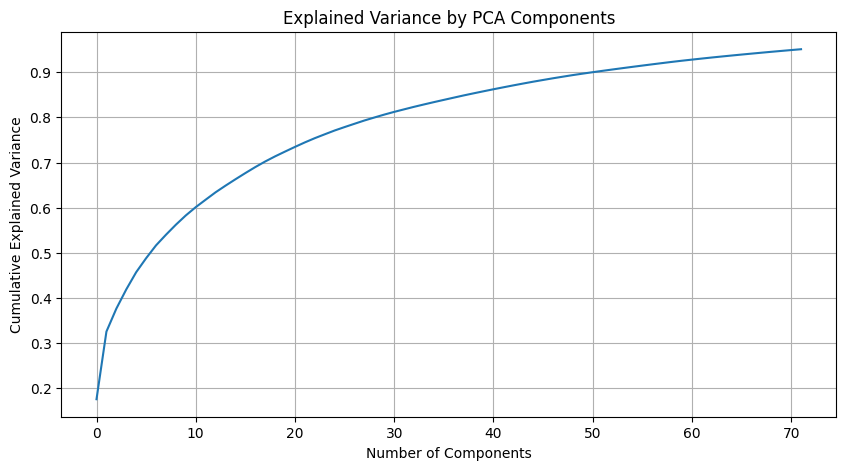

In [45]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

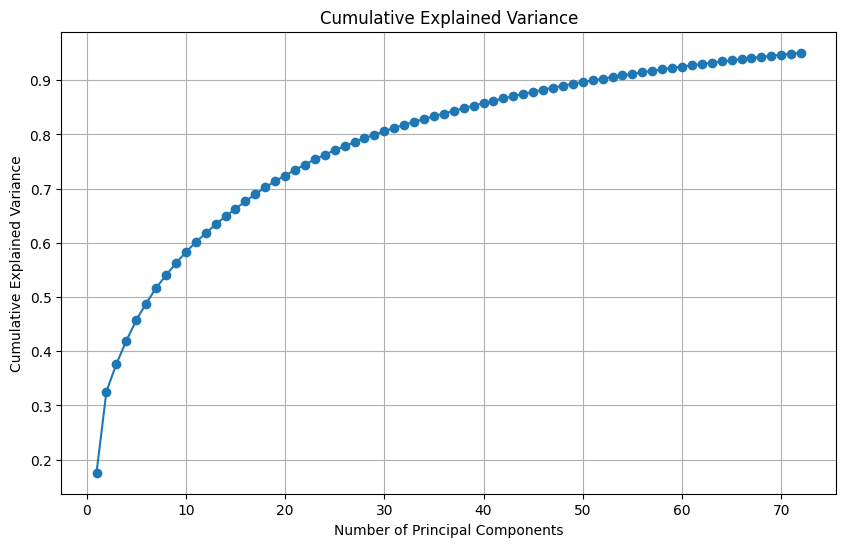

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

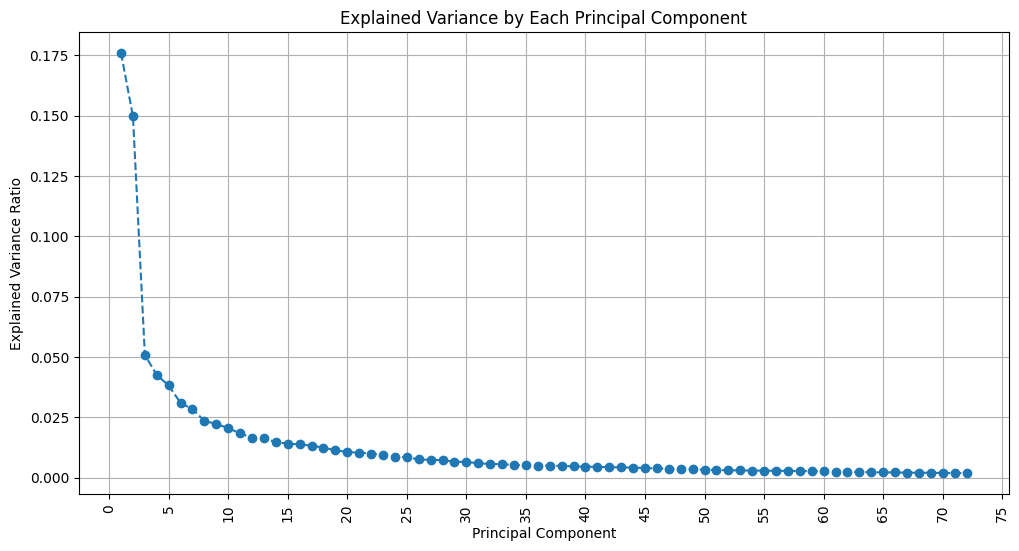

<Figure size 640x480 with 0 Axes>

In [47]:


# Number of components
n_components = len(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

# Set x-ticks to show all component numbers
plt.xticks(np.arange(0, n_components + 5, 5), rotation=90)

plt.grid(True)
plt.show()
plt.tight_layout()
plt.show()

In [48]:
# Assuming `pca` is your fitted PCA object
explained_variance_ratio = pca.explained_variance_ratio_
# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print cumulative variance explained by first 6 PCs
print(f"Cumulative variance explained by first 6 PCs: {cumulative_variance[5]:.4f}")


Cumulative variance explained by first 6 PCs: 0.4882


In [49]:
##I want to see loadings
pc_loadings = pd.DataFrame(
    pca.components_[:6],  # First 6 components
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(6)]
)

# Display all loadings (not truncated)
pd.set_option('display.max_columns', None)
print(pc_loadings)

     TransactionID  TransactionDT  TransactionAmt     card1     card2  \
PC1      -0.005592      -0.005460       -0.022498  0.002951  0.014064   
PC2       0.015936       0.016411        0.011370  0.009066  0.002384   
PC3      -0.018589      -0.017341       -0.003782  0.001965 -0.000366   
PC4       0.018270       0.018049        0.017863 -0.002762 -0.006049   
PC5      -0.008795      -0.008698       -0.023678  0.000535 -0.001068   
PC6       0.021563       0.020902        0.032163 -0.001011 -0.003479   

        card3     card5     addr1     addr2        C1        C2        C3  \
PC1  0.113658 -0.032024  0.002079 -0.027980  0.014122  0.016894  0.002436   
PC2 -0.041357 -0.009231  0.002089  0.010065 -0.005334 -0.006289  0.001113   
PC3  0.007614  0.000483  0.000776  0.002202  0.306834  0.305623 -0.001915   
PC4 -0.010494 -0.002179 -0.004732 -0.005514  0.001250  0.002419  0.000061   
PC5  0.012109  0.001635  0.007261 -0.006425 -0.040531 -0.043269 -0.003909   
PC6  0.000328  0.008890  0

In [50]:
# Top contributing features per PC
for i in range(6):
    print(f"\nTop features in PC{i+1}:")
    print(pc_loadings.iloc[i].abs().sort_values(ascending=False).head(10))


Top features in PC1:
V71    0.154123
V31    0.153766
V72    0.151391
V63    0.151313
V21    0.151205
V32    0.150725
V92    0.150017
V50    0.148870
V15    0.148582
V59    0.148451
Name: PC1, dtype: float64

Top features in PC2:
V128    0.172074
V308    0.172027
V127    0.171825
V96     0.171124
V97     0.171032
V280    0.170306
V134    0.170147
V103    0.169913
V318    0.169865
V102    0.169290
Name: PC2, dtype: float64

Top features in PC3:
C11    0.306874
C1     0.306834
C2     0.305623
C6     0.303030
C14    0.297490
C8     0.296555
C10    0.295361
C4     0.292765
C12    0.286773
C7     0.286744
Name: PC3, dtype: float64

Top features in PC4:
V116    0.238159
V114    0.237084
V108    0.227443
V110    0.226725
V113    0.216338
V111    0.215828
V123    0.207385
V115    0.204170
V125    0.201382
V112    0.196030
Name: PC4, dtype: float64

Top features in PC5:
V90     0.177251
V91     0.172494
V29     0.170360
V69     0.170310
V30     0.166441
V70     0.165141
V48     0.161170
V312   

In [51]:
# Threshold: how high a loading must be to count as "important"
threshold = 0.1  # Adjust as needed
# For each PC, get the features with loadings above the threshold
important_features_per_pc = []
for i in range(6):
    important = pc_loadings.iloc[i][pc_loadings.iloc[i] > threshold].index.tolist()
    important_features_per_pc.append(set(important))

# Find common features across all top 6 PCs
common_features = set.intersection(*important_features_per_pc)

print("Common important features across the top 6 PCs:")
print(common_features if common_features else "No common features found.")

Common important features across the top 6 PCs:
No common features found.


There are no common features across top 6 PCs.

In [52]:
print(train_data_cleaned[['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']].head())

KeyError: "['ProductCD', 'card4', 'card6', 'P_emaildomain'] not in index"